# Introducción al aprendizaje automatizado - TP 2
### Autora: Aldana Zarate

## Imports y funciones auxiliares generales

In [12]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from copy import deepcopy
import matplotlib.pyplot as plt
import tp0
import random
import warnings
warnings.filterwarnings("ignore")
import tp1ej4

# función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, 
# validación y test al terminar ese paso de entrenamiento. 
# Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
# entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas y la medida de eror a usar
# (segun sea regresión o clasificación)
# salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test, error_measure_func):
  best_red = None
  train_errors = []
  val_errors = []
  test_errors = []

  best_train_error = None
  best_val_error = None
  best_test_error = None
  for i in range(evaluaciones):
    red.fit(X_train, y_train)

    # Medimos los errores
    train_error_i = error_measure_func(red.predict(X_train), y_train)
    val_error_i = error_measure_func(red.predict(X_val), y_val)
    test_error_i = error_measure_func(red.predict(X_test), y_test)

    # Chequeo si la red es mejor que la candidata
    if best_val_error is None or val_error_i < best_val_error:
      best_val_error = val_error_i
      best_train_error = train_error_i
      best_test_error = test_error_i
      best_red = deepcopy(red)

    # Guardo los errores registrados en esta evaluacion
    train_errors.append(train_error_i)
    val_errors.append(val_error_i)
    test_errors.append(test_error_i)

  return best_red, train_errors, val_errors, test_errors, best_train_error, best_val_error, best_test_error

## Funciones para graficar

In [3]:
# Grafico en base a la cantidad de veces que entreno la red (epocas) o las diferentes cantidades de neuronas que se usaron
# m = range(epocas) o m = [cant. neuronas en la capa intermedia]
def graficar_curvas_errores(e_train, e_val, e_test, m):
  plt.plot(m,e_train,label="train",linestyle=":")
  plt.plot(m,e_val,label="validacion",linestyle="-.")
  plt.plot(m,e_test,label="test",linestyle="-")
  plt.legend()
  plt.show()

def graficar_predicciones(x, y, title):
  df = pd.DataFrame(x)
  df['Clase'] = y
  df.plot(x=0, y=1, kind='scatter', c = 'Clase', colormap='viridis', title = title)


## Ejercicio 1

In [ ]:
# Número de neuronas a ir usando
ns = [2, 10, 20, 40]

# Params
lr = 0.1
momentum = 0.9
evaluaciones = 1000
epocas = 20

# Datos para ajustar los modelos
random.seed()
train_data = tp0.generate_random_spirals(600)
train_samples = train_data[['x','y']]
train_target = train_data['Clase']
X_train, X_val, y_train, y_val = train_test_split(train_samples, train_target, test_size=0.2, random_state=0)

# Datos para test
test_data = tp0.generate_random_spirals(2000)

# Errores mínimos segun cant. de neuronas
best_train_errors = []
best_val_errors = []
best_test_errors = []

# Predicciones
y_test_preds = {}

for n in ns:
  clasif = MLPClassifier(hidden_layer_sizes=(n,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,
                         momentum=momentum,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas)
  
  best_red, train_errors, val_errors, test_errors, best_train_error, best_val_error, best_test_error = \
    entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, test_data[['x','y']], test_data['Clase'], sk.metrics.zero_one_loss)
  
  y_test_preds[n] = best_red.predict(test_data[['x','y']])
  best_train_errors.append(best_train_error)
  best_val_errors.append(best_val_error)
  best_test_errors.append(best_test_error)

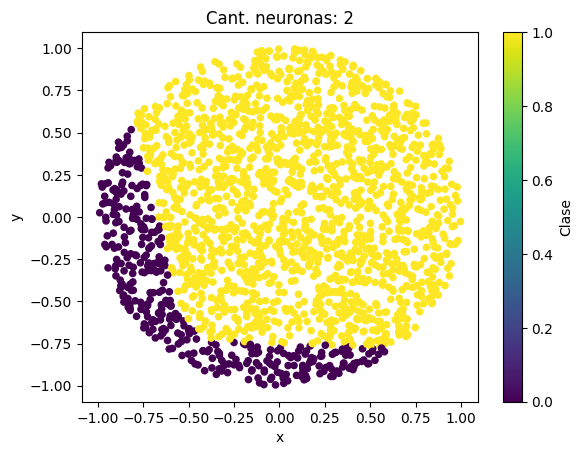

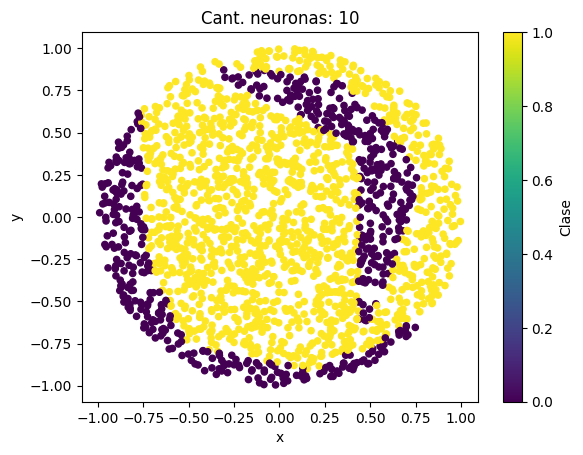

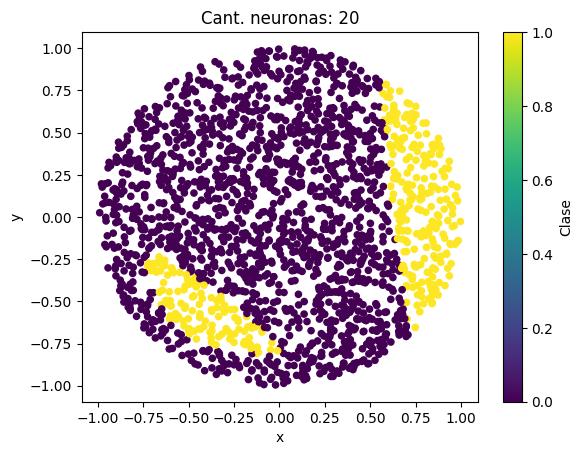

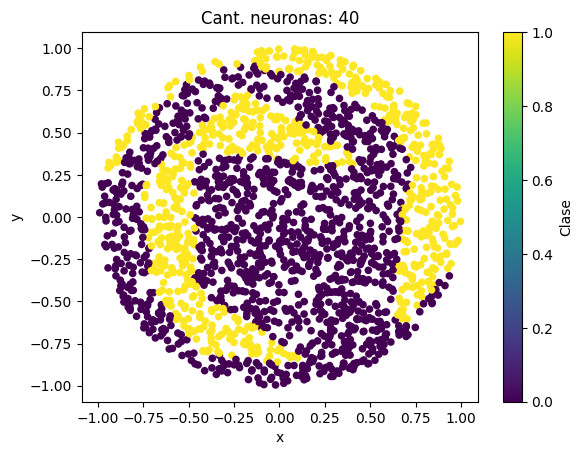

In [ ]:
# Graficas predicciones
for n in ns:
  graficar_predicciones(test_data[['x','y']], y_test_preds[n], f"Cant. neuronas: {n}")

Podemos observar que las gráficas esperadas de las espirales con las generadas por las redes están bastante lejanas entre sí. Recién con 40 neuronas se puede ver algo un poco más similar a una espiral, pero el resultado tampoco es aceptable. Cabe destacar que con n=40 se ve algo bastante llamativo, ya que se predijo en su mayoría todo como clase 0.

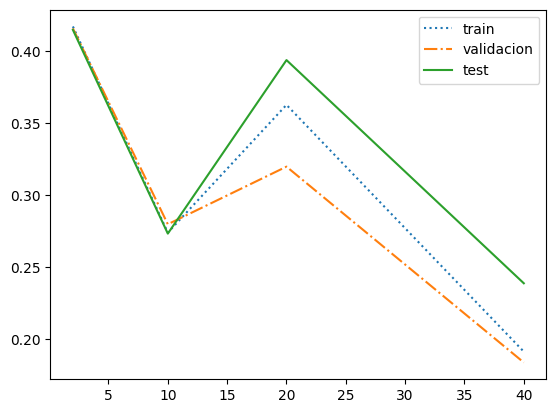

In [ ]:
# Grafica de errores
graficar_curvas_errores(best_train_errors, best_val_errors,best_test_errors, ns)

Se puede observar una diferencia notable entre los errores con 2 y 10 neuronas, además de que en cada punto todos ellos se solapan. Luego para 20 neuronas, los errores se distancian un poco más entre sí, habiendo en este punto un pico (en mi opinión) inusual. Mi hipótesis es que quedó así por la corrida de entrenamiento, ya que para 40 neuronas se nota un notable decrecimiento en los errores. 

## Ejercicio 2

In [4]:
patrones = 500
patrones_train = 400
patrones_val = 100
patrones_test = 2000

col_names = ['x','y','Clase']
df_data = pd.read_csv('dos_elipses.data', names=col_names)

sample_df_data = df_data.sample(n = patrones)
X_train, X_val, y_train, y_val = train_test_split(sample_df_data[['x','y']], sample_df_data['Clase'], test_size = 100, train_size = 400, random_state=0)

df_test = pd.read_csv('dos_elipses.test', names=col_names)  # el csv tiene 2000 justo asi que no es necesario samplearlo

neuronas = 6
evaluaciones = 300
epocas = 50
momentums = [0, 0.5, 0.9] # alfas
learning_rates = [0.1, 0.01, 0.001] # etas
entrenamientos = 10

etas = []
alfas = []
avg_test_errors = []  # lista de los errores promedios en 10 ejecuciones para un cierto valor de eta y alfa

min_errors_set = None # errores minimos (train, validación y test) en cada evaluacion correspondientes a los mejores valores de eta y alfa segun el criterio del avg
best_avg_test_error = None # candidato actual como minimo (considerando los promedios cada 10 entrenamientos)
best_alfa = None
best_eta = None

for alfa in momentums:
  for eta in learning_rates:
    alfas.append(alfa)
    etas.append(eta)
    # Candidatos para elegir los errores de la red que de mejores resultados
    min_local = None
    min_local_errors = None
    # Errores locales para despues promediarlos
    local_errors = []
    for e in range(entrenamientos):
      # Por los datos creo una red de clasificación
      red = MLPClassifier(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,
                         momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas)
      best_red, train_errors, val_errors, test_errors, best_train_error, best_val_error, best_test_error = \
    entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, df_test[['x','y']], df_test['Clase'], sk.metrics.zero_one_loss)

      local_errors.append(best_test_error)

      if min_local is None or best_test_error < min_local:
        min_local = best_test_error
        min_local_errors = (train_errors, val_errors, test_errors)
    
    # Promediamos los valores para estos 10 iteraciones con este alfa y eta
    avg_min_local = sum(local_errors)/entrenamientos
    avg_test_errors.append(avg_min_local)

    # Analizamos qué tan buenos fueron este eta y alfa comparando los promedios
    if best_avg_test_error is None or avg_min_local < best_avg_test_error:
      best_avg_test_error = avg_min_local
      best_alfa = alfa
      best_eta = eta
      min_errors_set = min_local_errors

datos_tabla = {'Momentum': alfas, 'Learning rate': etas, 'Test Error': avg_test_errors}

df = pd.DataFrame(datos_tabla)
df.to_csv('ej2/datos_tabla.csv')
#files.download('datos_tabla.csv') 

datos_errores = {'e_train': min_errors_set[0], 'e_val': min_errors_set[1] , 'e_test': min_errors_set[2]}
df_errors = pd.DataFrame(datos_errores)
df_errors.to_csv('ej2/datos_errores.csv')
#files.download('datos_errores.csv') 

In [13]:
# Confeccionamos una tabla con los valores usados para los parámetros y el resultado en test obtenido (la media de las 10 ejecuciones)
datos_tabla = pd.read_csv('ej2/datos_tabla.csv')
datos_tabla = datos_tabla.drop('Unnamed: 0', axis=1)
datos_tabla.sort_values(by=['Test Error'])

,Momentum,Learning rate,Test Error
6,0.9,0.100,0.15195
3,0.5,0.100,0.17440
7,0.9,0.010,0.18780
0,0.0,0.100,0.18990
4,0.5,0.010,0.19065
8,0.9,0.001,0.19690
1,0.0,0.010,0.20895
5,0.5,0.001,0.21985
2,0.0,0.001,0.22985


Se puede observar que el error mínimo fue con momentum 0.9 y leaning rate 0.1. También se puede destacar que los valores de error correspondientes al learning rate 0.1 están dentro de los más pequeños. Del lado del momentum, podemos ver que los valores relacionados al 0.9 suelen tener menos error, los de 0.5 menos y los momentum iguales a 0 suelen tener mayor error. Algo llamativo es que los valores de error correspondientes a 0.001 solieron tener mayor error, esto quizás puede ser debido a la aletoreidad o porque con el número de épocas usado no alcance para converger a tiempo a una solución. 

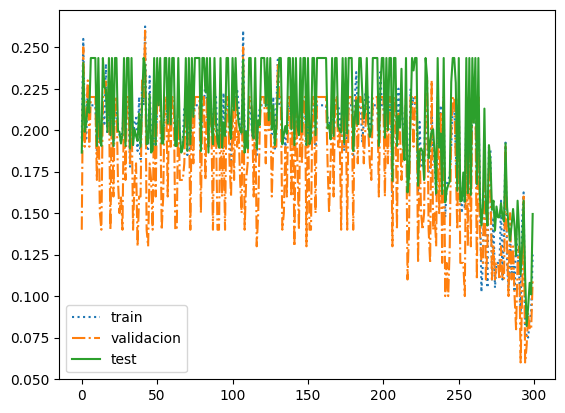

In [24]:
# gráfica de mse de train, validación y test en función del número de épocas para los valores seleccionados (los mejores valores de eta y alfa)
datos_errores = pd.read_csv('ej2/datos_errores.csv')
datos_errores = datos_errores.drop('Unnamed: 0', axis=1)
graficar_curvas_errores(datos_errores['e_train'], datos_errores['e_val'], datos_errores['e_test'], range(300))

Se puede observar que los errores de train y test se solapan en la mayoría de los entrenamientos. A partir de las últimas tandas de épocas (desde la evaluación nro 250 aproximadamente) se observa un descenso importante en el error. Sim embargo, antes de estas épocas los errores son bastante poco aceptables por lo altos que son. 

## Ejercicio 3

In [25]:
# Regresion
#ikeda.data length = 100
#ikeda.test length = 4800

val_proportions = [0.05, 0.25, 0.5] # resto training
test_size = 2000

col_names = ['v','w','x','y','z','Target']
df_train = pd.read_csv('ikeda.data', names=col_names, delim_whitespace=True)

df_test = (pd.read_csv('ikeda.test', names=col_names, delim_whitespace=True)).sample(n = test_size)

neuronas = 30
evaluaciones = 400
epocas = 50
momentum = 0.9 # alfa
learning_rate = 0.01 # eta
# Dejamos este valor por default para la cantidad de entrenamientos
entrenamientos = 10

best_errores = {}

for val_size_proportion in val_proportions:
  candidate_val_error = None
  X_train, X_val, y_train, y_val = train_test_split(
  df_train[['v','w','x','y','z']], df_train['Target'],
  test_size = val_size_proportion, random_state=0)
  for e in range(entrenamientos):
    # Por los datos creo una red de regresión
    red = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant',
                        learning_rate_init=learning_rate,momentum=momentum,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas)
    best_red, train_errors, val_errors, test_errors, best_train_error, best_val_error, best_test_error = \
  entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, df_test[['v','w','x','y','z']], df_test['Target'], sk.metrics.mean_squared_error)

    if candidate_val_error is None or best_val_error < candidate_val_error:
      candidate_val_error = best_val_error
      best_errores[val_size_proportion] = (train_errors, val_errors, test_errors)

for val_size_proportion in val_proportions:
  datos_errores = {'e_train': best_errores[val_size_proportion][0], 'e_val': best_errores[val_size_proportion][1] ,
                    'e_test': best_errores[val_size_proportion][2]}
  df_errors = pd.DataFrame(datos_errores)
  path = 'ej3/datos_errores_'+str(val_size_proportion)+'.csv'
  df_errors.to_csv(path)
  #files.download(path) 

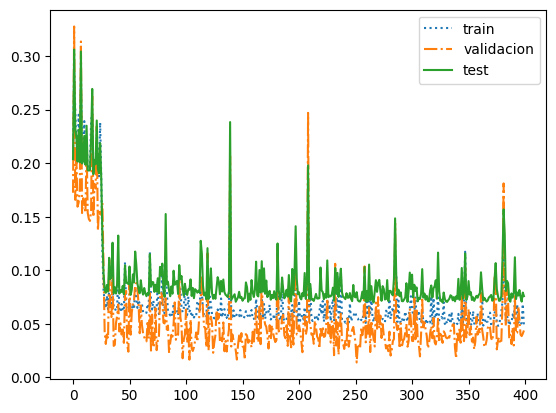

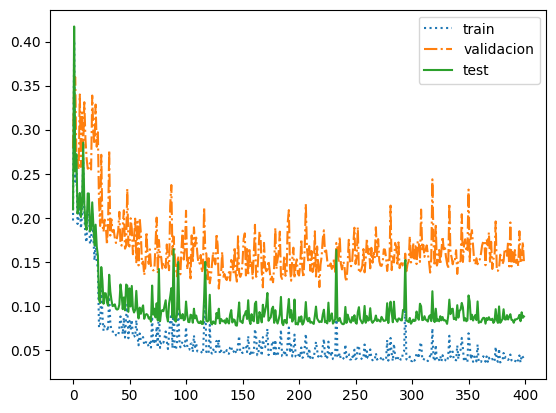

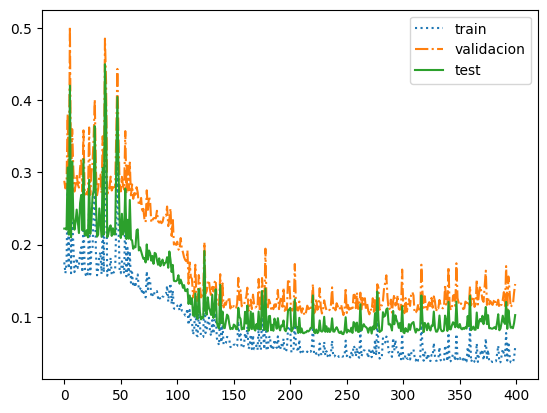

In [4]:
for val_size in [0.05, 0.25, 0.5]:
    path = 'ej3/datos_errores_'+str(val_size)+'.csv'
    datos_errores = pd.read_csv(path)
    datos_errores = datos_errores.drop('Unnamed: 0', axis=1)
    graficar_curvas_errores(datos_errores['e_train'], datos_errores['e_val'], datos_errores['e_test'], range(400))

Las gráficas de arriba se corresponden con errores correspondientes a las proporciones 0.05, 0.25 y 0.5 de validación respectivamente, graficadas en función de las evaluaciones para cada valor. Podemos observar que en las últimas dos gráficas (correspondientes a un conjuntos de validación más pequeños) el error de validación se encuentra muy por encima comparado con la 1era gráfica. Para el primer cuarto de evaluaciones, también se puede notar un error de test más alto (luego se estabiliza) para estas proporciones.

En la primera gráfica, se observa un pico para todos los errores, que luego desde la evaluación 25 aproximadamente decrece rápidamente y luego se estabiliza en un valor bastante aceptable.

Como conclusión podemos decir que al tener un conjunto de validación más pequeño, se poseen más datos para entrenar y podemos así minimizar un poco más los errores. Ya que, mientras menos datos haya de entrenamiento, más chances hay de sobreajuste al volverse más particular. Aunque, si se usa un conjunto de validación muy pequeño como en el primer caso, puede pasar que no se obtengan buenos resultados si los elementos de dicho conjunto son todos outliers.

# Ejercicio 4


In [5]:
def entrenar_red_regresion_ej4(red, evaluaciones, X_train, y_train, X_test, y_test):
    best_red = None
    best_test_error = None

    train_errors = []
    penalty_errors = []
    test_errors = []

    for i in range(evaluaciones):
        red.fit(X_train, y_train)
        error = sum(map(lambda x : np.sum(np.power(x, 2)), red.coefs_))
        penalty_errors.append(error)

        # Medimos los errores
        train_error_i = sk.metrics.mean_squared_error(red.predict(X_train), y_train)
        test_error_i = sk.metrics.mean_squared_error(red.predict(X_test), y_test)

        # Chequeo si la red es mejor que la candidata
        if best_test_error is None or test_error_i < best_test_error:
            best_test_error = test_error_i
            best_red = deepcopy(red)

        # Guardo los errores registrados en esta evaluacion
        train_errors.append(train_error_i)
        test_errors.append(test_error_i)

    return best_red, train_errors, penalty_errors, test_errors, best_test_error

col_names = list(range(13))

train_data = pd.read_csv('ssp.data', names=col_names)
test_data = pd.read_csv('ssp.test', names=col_names)

X_train = train_data[col_names[0 : 12]]
y_train = train_data[[12]]

X_test = test_data[col_names[0 : 12]]
y_test = test_data[[12]]

gammas = [10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)]

best_gamma = None
candidate_test_error = None 
best_penalty_errors = None
best_train_errors = None 
best_test_errors = None

for gamma in gammas:
    regr = MLPRegressor(
            hidden_layer_sizes=(6,), 
            activation='logistic', 
            solver='sgd', 
            alpha=gamma, 
            batch_size=1, 
            learning_rate='constant', 
            learning_rate_init=0.05,
            momentum=0.3,
            nesterovs_momentum=False,
            tol=0.0,
            warm_start=True,
            max_iter=20
        )
    
    best_red, train_errors, penalty_errors, test_errors,best_test_error = \
        entrenar_red_regresion_ej4(regr, 4000, X_train, y_train, X_test, y_test)
    
    # Guardamos los errores obtenidos para observar luego si hubo alguno con sobreajuste
    datos_errores = {'e_train': train_errors, 'e_test': test_errors, 'e_penalty': penalty_errors}
    df_errors = pd.DataFrame(datos_errores)
    path = 'ej3/datos_errores_gamma_'+str(gamma)+'.csv'
    df_errors.to_csv(path)
    #files.download(path)
    
    if candidate_test_error is None or best_test_error < candidate_test_error:
        candidate_test_error = best_test_error
        best_gamma = gamma
        best_train_errors = train_errors
        best_penalty_errors = penalty_errors
        best_test_errors = test_errors


datos_errores = {'e_train': best_train_errors, 'e_test': best_test_errors, 'e_penalty': best_penalty_errors}
df_errors = pd.DataFrame(datos_errores)
path = 'ej3/datos_errores_bestgamma_'+str(best_gamma)+'.csv'
df_errors.to_csv(path)
#files.download(path) 

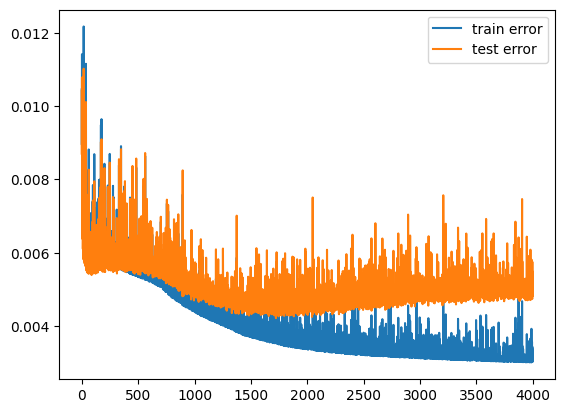

In [27]:
evaluaciones = range(4000)
datos_errores = pd.read_csv('ej4/datos_errores_bestgamma_1e-06.csv')
datos_errores = datos_errores.drop('Unnamed: 0', axis=1)
plt.plot(evaluaciones, datos_errores['e_train'], label = 'train error')
plt.plot(evaluaciones, datos_errores['e_test'], label = 'test error')
plt.legend()
plt.show()

Podemos observar que el mejor gamma encontrado fue el de valor 1e-06. Arriba se pueden observar los errores de train y test para este valor de gamma. Comparemos sus resultados con los otros encontrados:




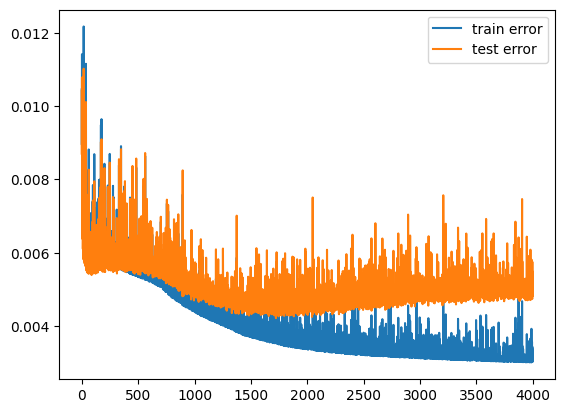

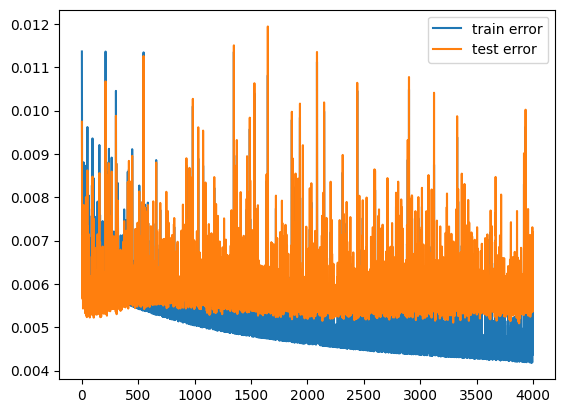

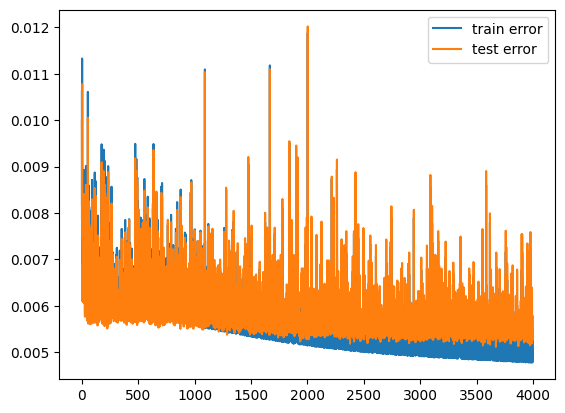

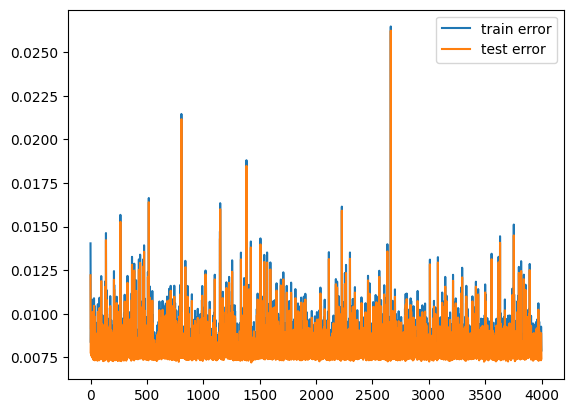

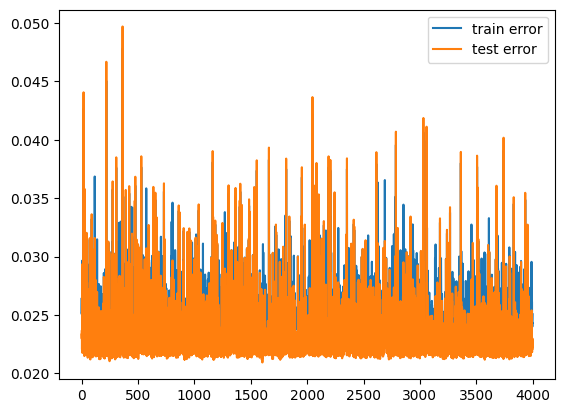

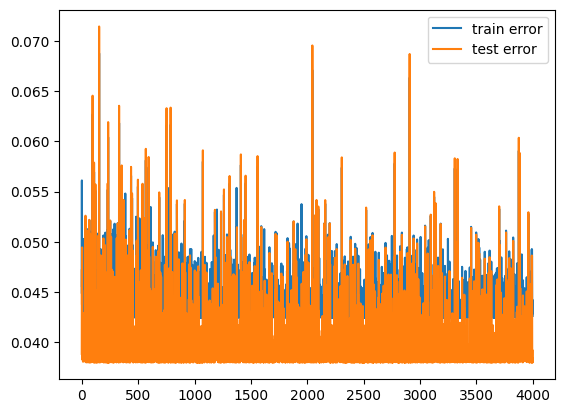

In [21]:
for gamma in [10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1)]:
    path = 'ej4/datos_errores_gamma_'+str(gamma)+'.csv'
    datos_errores = pd.read_csv(path)
    datos_errores = datos_errores.drop('Unnamed: 0', axis=1)
    plt.plot(evaluaciones, datos_errores['e_train'], label = 'train error')
    plt.plot(evaluaciones, datos_errores['e_test'], label = 'test error')
    plt.legend()
    plt.show()

Se puede observar que mientras mayor sea el gamma, mayor son los errores (tanto de train como de test). En ningún caso particular se observa un caso con un sobreajuste notable.

Veamos la gráfica del error de penalización para el mejor gamma:

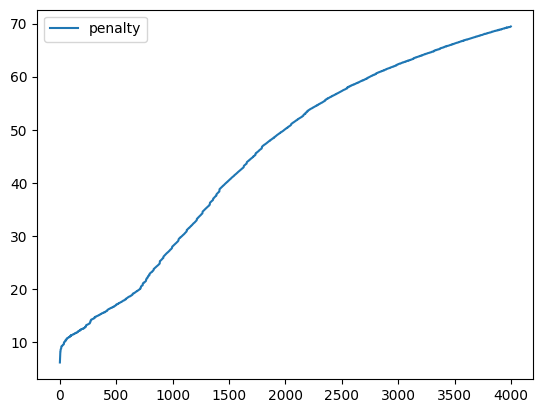

In [28]:
datos_errores = pd.read_csv('ej4/datos_errores_bestgamma_1e-06.csv')
datos_errores = datos_errores.drop('Unnamed: 0', axis=1)
plt.plot(list(evaluaciones), datos_errores['e_penalty'], label = 'penalty', linestyle="-")
plt.legend()
plt.show()

Se puede observar que el error de penalización crece (a un ritmo bastante notable) cuando las evaluaciones crecen.

# Ejercicio 5

In [ ]:
# Modifico la función de entrenamiento de redes de clasificación para que se adapte al modelo de los árboles
def entrenar_red_clasificacion_ej5(red, evaluaciones, X_train, y_train, X_test, y_test):
    best_red = None
    best_test_error = None
    best_train_error = None

    train_errors = []
    test_errors = []

    for i in range(evaluaciones):
        red.fit(X_train, y_train)

        # Medimos los errores
        train_error_i = sk.metrics.zero_one_loss(red.predict(X_train), y_train)
        test_error_i = sk.metrics.zero_one_loss(red.predict(X_test), y_test)

        # Chequeo si la red es mejor que la candidata
        if best_test_error is None or test_error_i < best_test_error:
            best_test_error = test_error_i
            best_train_error = train_error_i
            best_red = deepcopy(red)

        # Guardo los errores registrados en esta evaluacion
        train_errors.append(train_error_i)
        test_errors.append(test_error_i)

    return best_red, train_errors, test_errors, best_train_error, best_test_error

# Ejercicio 4 del TP de árboles versión redes

# Valores de d
d_iterable = [2, 4, 8, 16, 32]

# Datos a guardar pedidos
train_errors_d = []
test_errors_d = []

train_errors_p = []
test_errors_p = []

# Guardo la dimension que va teniendo d para poder armar el dataframe a la hora de analizar
dimensions = []

for d in d_iterable:
    # Conjuntos de test
    # Diagonal
    d_test = tp0.generate_dataframe_ej_a(d, 10000, 0.78)
    cols = range(0, d)
    X_d_test = d_test[cols]
    y_d_test = d_test['Clase']

    # Paralelo
    p_test = tp0.generate_dataframe_ej_b(d, 10000, 0.78)
    X_p_test = p_test[cols]
    y_p_test = p_test['Clase']
    
    for i in range(0,20):
        # Longitud del conjunto de entrenamiento
        dimensions.append(d)

        # Conjuntos de entrenamiento diagonal
        train_set_d = tp0.generate_dataframe_ej_a(d, 250, 0.78)
        X_d_train = train_set_d[cols]
        y_d_train = train_set_d['Clase']

        # Conjuntos de entrenamiento paralelo
        train_set_p = tp0.generate_dataframe_ej_b(d, 250, 0.78)
        X_p_train = train_set_p[cols]
        y_p_train = train_set_p['Clase']

        # Redes y entrenamiento diagonal (usamos los parámetros obtenidos en el ejercicio 2)
        clasif_d = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant',
                                learning_rate_init=0.1,momentum=0.9,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=50)
        best_red_d, all_train_errors_d, all_test_errors_d, best_train_error_d, best_test_error_d = \
        entrenar_red_clasificacion_ej5(clasif_d, 300, X_d_train, y_d_train, X_d_test, y_d_test)

        # Redes y entrenamiento paralelo
        clasif_p = MLPClassifier(hidden_layer_sizes=(6,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant',
                                learning_rate_init=0.1,momentum=0.9,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=50)
        best_red_p, all_train_errors_p, all_test_errors_p, best_train_error_p, best_test_error_p = \
        entrenar_red_clasificacion_ej5(clasif_p, 300, X_p_train, y_p_train, X_p_test, y_p_test)


        # Guardamos errores sobre el conjunto de entrenamiento y de testeo.
        train_errors_d.append(best_train_error_d)
        test_errors_d.append(best_test_error_d)

        train_errors_p.append(best_train_error_p)
        test_errors_p.append(best_test_error_p)

# Armo dataframe con los datos colectados anteriormente
temp_dataframe_d = pd.DataFrame({})
temp_dataframe_d['D'] = dimensions
temp_dataframe_d['TrainError'] = train_errors_d
temp_dataframe_d['TestError'] = test_errors_d

temp_dataframe_p = pd.DataFrame({})
temp_dataframe_p['D'] = dimensions
temp_dataframe_p['TrainError'] = train_errors_p
temp_dataframe_p['TestError'] = test_errors_p

# Dataframes finales a usar para la gráfica
df_errors_d = pd.DataFrame({})
df_errors_d['Dimension'] = d_iterable
df_errors_d['TrainError'] = temp_dataframe_d.groupby('D')['TrainError'].mean().to_numpy()
df_errors_d['TestError'] = temp_dataframe_d.groupby('D')['TestError'].mean().to_numpy()

path = 'datos_errores_redes_d.csv'
df_errors_d.to_csv(path)
#files.download(path)

df_errors_p = pd.DataFrame({})
df_errors_p['Dimension'] = d_iterable
df_errors_p['TrainError'] = temp_dataframe_p.groupby('D')['TrainError'].mean().to_numpy()
df_errors_p['TestError'] = temp_dataframe_p.groupby('D')['TestError'].mean().to_numpy()

path = 'datos_errores_redes_p.csv'
df_errors_p.to_csv(path)
#files.download(path)

Text(0, 0.5, 'Error')

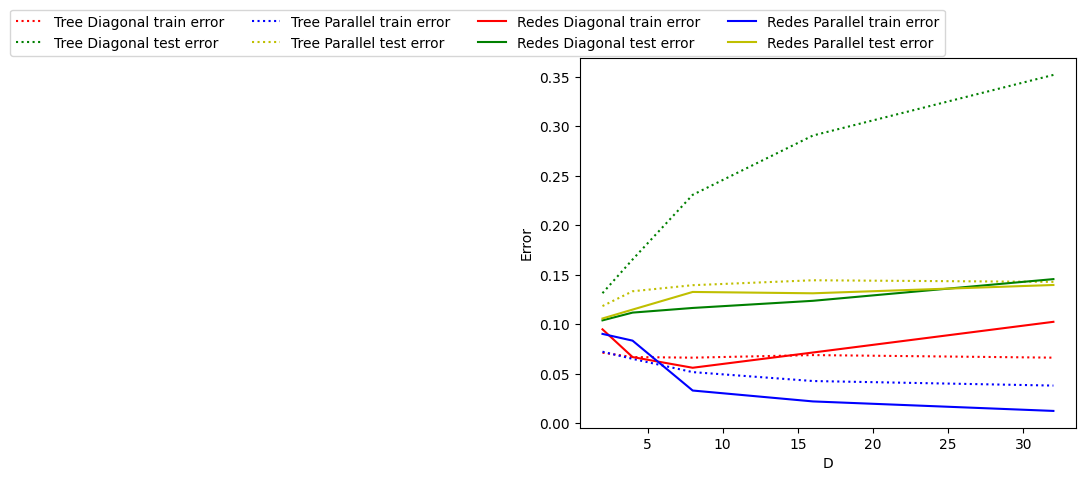

In [20]:
path = 'ej5/datos_errores_redes_d.csv'
datos_errores_redes_d = pd.read_csv(path)
datos_errores_redes_d = datos_errores_redes_d.drop('Unnamed: 0', axis=1)

path = 'ej5/datos_errores_redes_p.csv'
datos_errores_redes_p = pd.read_csv(path)
datos_errores_redes_p = datos_errores_redes_p.drop('Unnamed: 0', axis=1)

df_errors_d, df_errors_p = tp1ej4.obtainTreesData()

plt.plot(df_errors_d['Dimension'], df_errors_d['TrainError'], 'r', linestyle=":")
plt.plot(df_errors_d['Dimension'], df_errors_d['TestError'], 'g', linestyle=":")
plt.plot(df_errors_p['Dimension'], df_errors_p['TrainError'], 'b', linestyle=":")
plt.plot(df_errors_p['Dimension'], df_errors_p['TestError'], 'y', linestyle=":")
plt.plot(datos_errores_redes_d['Dimension'], datos_errores_redes_d['TrainError'], 'r')
plt.plot(datos_errores_redes_d['Dimension'], datos_errores_redes_d['TestError'], 'g')
plt.plot(datos_errores_redes_p['Dimension'], datos_errores_redes_p['TrainError'], 'b')
plt.plot(datos_errores_redes_p['Dimension'], datos_errores_redes_p['TestError'], 'y')
plt.legend(['Tree Diagonal train error', 'Tree Diagonal test error', 'Tree Parallel train error', 'Tree Parallel test error',
            'Redes Diagonal train error', 'Redes Diagonal test error', 'Redes Parallel train error', 'Redes Parallel test error'],
            bbox_to_anchor=(0.75, 1.15), ncol=4)
plt.xlabel("D")
plt.ylabel("Error")


Podemos observar que las redes no las afecta las dimensiones, ya que a diferencia de los árboles, a medida que D crece, las curvas de error se mantienen bastante "aplanadas". Además, casi no se observan diferencias entre los errores de test del paralelo y el diagonal, a diferencia de los árboles que la diferencia entre las curvas de error de test de estos problemas es enorme. 

Si comparamos las curvas de error de entrenamiento de árboles y redes, podemos ver que no hay tantas diferencias. En redes, el problema paralelo tiene menor error que el de árboles y que el diagonal.

PD: no entrego los opcionales porque me quiero poner con el TP de Bayes (que pensaba entregarlo a tiempo pero no recordaba que necesitaba los resultados de este TP :) ) . La idea es hacer los opcionales para el examen final así tengo presente los resultados vistos (ya que si son cosas que tardan 4 horas en correr, prefiero darle prioridad a Bayes ahora).